In [17]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [18]:
# 훈련용 MNIST 데이터셋 다운로드
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [19]:
# 데이터 전처리
# 일반적으로 0~1인 sigmoid보다 -1~1인 HyperTangent가 더 출력범위도 넓고 경사면이 커 빠르게 수렴하여 학습하기에 -1~1 사이의 값으로 정규화 
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (train_images - 127.5) / 127.5
# shape : 머신러닝 에선 행렬의 차원을 shape라는 개념으로 표현함 
# reshape : 배열의 차원이 크기를 변경하는 기능 

In [20]:
# 추가적인 숫자 데이터 입력
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)
# 데이터 원핫벡터로 변경 Ex)4의 경우 (0,0,0,0,1,0,0,0,0,0,0)
train_label_onehots.shape

(60000, 10)

In [21]:
# 훈련용 이미지의 차원 출력 
# train_images.shape

In [22]:
# buffer에 60000개의 file 가져오도록 설정
BUFFER_SIZE = 60000
BATCH_SIZE = 128
# 그중 128개를 선택하여 DataSet으로 결정
# 대량의 데이터를 표현하기 위하여 tf.data.Dataset API 호출후 이어지는 .from_tensor_slices로 데이터를 나누어줌 그후 shuflle로 섞기. 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [23]:
# Generator 생성자 모델 생성
# 생성자 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델 
# input : 100차원의 noise
# output : MNIST의 이미지 크기인 28 * 28 
# Dense : 입출력을 모두 연결해주는 기능을 가진 layer
inputs = keras.Input(shape = (100,))
x = inputs
x = layers.Dense(256)(x)
# 은닉층의 경우는 relu함수를 활성화 함수로 사용
x = layers.LeakyReLU()(x)
x = layers.Dense(28 * 28, activation = 'tanh')(x)
# 출력을 MNIST의 이미지에 맞게 변경
outputs = layers.Reshape((28,28))(x)

In [24]:
# 선형적인 흐름으로 흘러가는 Sequentai()을 사용하여도 되지만 비선형구조에도 적용이 가능한 keras.Model 이라는 기능을 사용한다.
G = keras.Model(inputs, outputs)
# summary로 요약본 출력
G.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 227,344
Trainable params: 227,344
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Discriminator 판별자 모델 생성
# 판별자 모델은 생성된 28 * 28 이미지가 실제 데이터인지 만들어진 데이터인지 판별함
# output : 실제 데이터 일 확률을 0 과 1 의 값으로 판별
inputs = keras.Input(shape = (28,28,1))
# Flatten : 입력받은 다차원을 1차원 으로 변경
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
# 과적합 방지를 위해 dropout 기법을 사용 
# dropout : 임의의 뉴런을 삭제하여 신호를 전달하게 않게함으로써 특정한 Feature만을 학습하지 않게함.
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)

In [26]:
D = keras.Model(inputs, outputs)
D.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 201,217
Trainable params: 201,217
Non-trainab

In [27]:
# epochs : 반복횟수 
# noise_dim = gan에 입력되는 noise에 대한 dimension(차원)
EPOCHS = 120 
noise_dim = 100 

# 차후 하이퍼 파라미터 수정을 위해 seed를 저장하여 예측된 값을 출력하도록 설정
seed = tf.random.normal([BATCH_SIZE, noise_dim])

# optimizer : (최적화알고리즘)손실 함수(loss Function)를 통해 얻은 손실값으로 부터 모델을 업데이트 하는 방법 본 코드에서는 Adam을 사용하였음, 
G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [28]:
# 손실함수인 교차엔트로피를 사용하기위해 설정
# 이진 교차 엔트로피를 사용시 from_logits 옵션을 주지않으면 outputlayer에 sigmoid를 추가하여야하나 본 코드 에서는 from_logits 옵션에 True를 선언 하였기에
# 자동으로 로지스틱 회귀(sigmoid Func)로 변경된다 
# logistic regression : 두가지의 결과값만이 있을때 선형 결합을 이용하여 발생 가능성을 예측하는데 사용되는 통계 기법
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 판별자모델의 손실률 계산
def D_loss(real_output, fake_output):
    # tf.ones_likes : 모든 값이 1인 텐서 생성 1 = 정답(진품)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # tf.zeros_likes : 모든 값이 0인 텐서 생성 0 = 오답(가품)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 생성자모델의 손실률 계산
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
# 학습
# train_step 함수에는 @tf.function이라는 데코레이터가 사용됨
# python에서의 데코레이터는 특정 상황에 함수를 compile하여 기능을 추가하거나 속도를 증대시킴.
@tf.function
def train_step(real_images):  
  # 랜덤 정규 분포된 noise를 생성
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  # GradientTape : 자동 미분을 도와줌
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G(noises, training=True)
    #fake_images = G(seed, training=True)
    
    real_output = D(real_images, training=True)
    fake_output = D(fake_images, training=True)
    
    #G모델은 가짜를 출력 #D모델은 진짜와 가짜를 출력.
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables)) 
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))
  

In [30]:
# 모델 평가

def test_step(real_images):  
  # 노이즈 = 난수정규분포([배치크기,노이즈갯수])
  noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
  fake_images = G(noises, training=False)
  
  real_output = D(real_images, training=False)
  fake_output = D(fake_images, training=False)    
  
  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)
  
  print("생성자 손실률:", gen_loss.numpy(), "판별자 손실률:", dsc_loss.numpy())

In [31]:
# 학습 함수

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    # dataset을 열거하며 i image_batch에 전달함
    for i, image_batch in enumerate(dataset):
      train_step(image_batch)
      if i == 0:
        test_step(image_batch)
      
    print (f'반복 횟수 : {epoch + 1} 에 걸린 시간 {(round(time.time()- start))} 초 입니다.')

In [32]:
%%time
train(train_dataset, EPOCHS)

생성자 손실률: 0.672022 판별자 손실률: 0.80865645
반복 횟수 : 1 에 걸린 시간 10 초 입니다.
생성자 손실률: 1.7028694 판별자 손실률: 0.26013622
반복 횟수 : 2 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.5253309 판별자 손실률: 0.3457828
반복 횟수 : 3 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.5248159 판별자 손실률: 0.4077144
반복 횟수 : 4 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.189434 판별자 손실률: 0.6205275
반복 횟수 : 5 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.2779224 판별자 손실률: 0.58173585
반복 횟수 : 6 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.1493478 판별자 손실률: 0.69418323
반복 횟수 : 7 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.2847588 판별자 손실률: 0.5936421
반복 횟수 : 8 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.6761329 판별자 손실률: 0.38455576
반복 횟수 : 9 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.8628447 판별자 손실률: 0.38222724
반복 횟수 : 10 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.7244245 판별자 손실률: 0.40962565
반복 횟수 : 11 에 걸린 시간 9 초 입니다.
생성자 손실률: 1.887697 판별자 손실률: 0.37483275
반복 횟수 : 12 에 걸린 시간 11 초 입니다.
생성자 손실률: 1.6574748 판별자 손실률: 0.52337056
반복 횟수 : 13 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.5664101 판별자 손실률: 0.4997406
반복 횟수 : 14 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.3000679 판별자 손실률: 0.6282429
반복 횟수 : 15 에 걸린 시간 6 초 입니다.
생성자 손실률: 1.

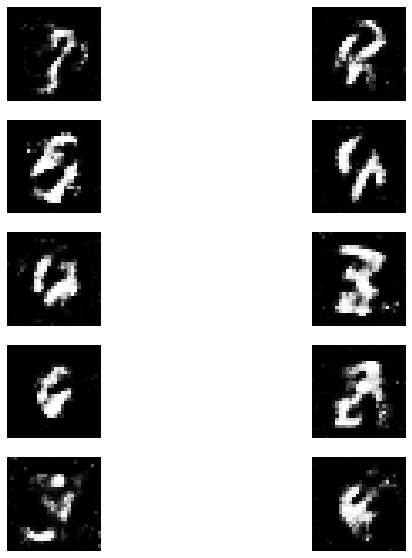

In [33]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

noises = tf.random.normal([50, 100])
# 훈련되지 않은 생성자모델의 이미지 
generated_image = G(noises, training=False)
# 훈련된 생성자모델의 이미지 
#generated_image = G(noises, training=True)
# plt 이용하여 출력.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

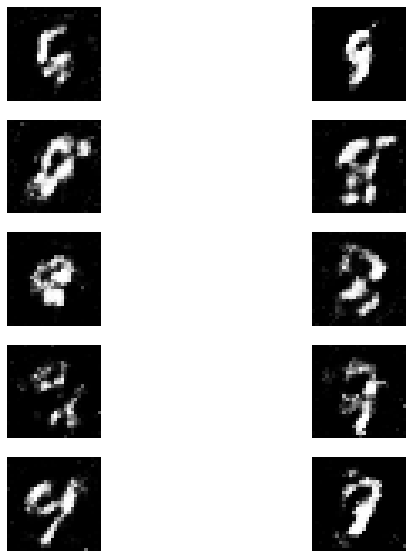

In [34]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

noises = tf.random.normal([50, 100])
# 훈련되지 않은 생성자모델의 이미지 
#generated_image = G(noises, training=False)
# 훈련된 생성자모델의 이미지 
generated_image = G(noises, training=True)
# plt 이용하여 출력.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()